## 4.1 자세 추정 및 오픈포즈 개요

#### 4.1.1 자세 추정 개요
* 자세 추정
    * 이미지에 포함된 여러 인물을 탐지하여 **인체 각 부위의 위치를 식별**
    * **인체 각 부위를 연결하는 선(링크)**을 구함

#### 4.1.2 MSCOCO 데이터셋 및 자세 추정의 어노테이션 데이터
* MSCOCO
    * 이미지 데이터, 어노테이션 데이터가 있음
        * 어노테이션 데이터: JSON 형식
            * 이미지의 주요 인물 정보(`joint_self`)와 그 외 인물 정보(`joint_others`)로 나누어 저장
        * 동일한 이미지의 어노테이션에서 주요인물의 정보가 다를 수 있음
    * **캡션 어노테이션 데이터**가 있음
        * 해당 이미지가 무엇을 나타내는지 설명
        * 이미지에 캡션 데이터를 생성하는 딥러닝 데이터셋으로 활용
    * MSCOCOC 중 **인물이 있고, 인체의 부위와 인물의 어노테이션이 부여된 데이터 사용**
    * MSCOCO 자세 추정용 데이터: COCO Keypoint Detection Task(COCO 키포인트 인식 작업에 사용)

#### 4.1.3 오픈포즈를 활용한 자세 추정 흐름
* 본질적인 내용은 시맨틱 분할과 거의 비슷!
    * 이미지에서 픽셀 수준으로 클래스(신체 부위) 판정
    * 시맨틱 분할
        * 픽셀별 클래스 분류 문제
    * 오픈포즈
        * 픽셀별 회귀문제
        
        
* 신체부위끼리 어떻게 연결할까,,?!
    * 하향식 접근 방식
        * 물체감지로 인물을 검출 → 한 사람의 이미지만 잘라서 자세 추정
        * 이미지에서 한 사람만 추출되기 때문에 어느 쌍으로 연결할지 문제 해결!
        * 인물이 많아지면 처리 시간 증가, 정밀도와 정확도에 영향을 끼치게 됨
    * **상향식 접근 방식**
        * OpenPose에서 사용하는 방식
        * 링크 쌍 문제를 해결하기 위해 **PAFs** 사용
            * 부위간 연결성을 나타내는 지표


* OpenPose를 활용한 자세 추정 3단계
    1. 전처리
        * 이미지 사이즈: 368⨉368
        * 색상정보 표준화
    2. 신경망에 전처리한 이미지 입력
        * 출력: 부위(19⨉368⨉368)배열과 PAFs(38⨉368⨉368)배열
        * 출력 배열의 값은 각 픽셀이 각 클래스일 신뢰도에 대응
    3. 신체 부위의 출력 결과에서 각 부위별 좌표를 정함<br> PAFs 정보와 함께 링크를 구함<br> 이미지 크기 원 상태로

## 4.2 데이터셋과 데이터 로더 구현


#### 4.2.1 마스크 데이터란
* 이미지에 사람이 있지만 어노테이션 데이터가 없는 상태는 자세 추정 학습에 좋지 않음
    * 훈련 및 검증용 이미지에서 이미지에 존재하나 <br> 자세 어노테이션 데이터가 없는 인물정보는 검게 칠하는 마스크를 적용
* 손실함수 계산시 신체 부위로 검출된 좌표 위치에 마스크된 픽셀의 결과를 손실 계산에서 무시함!!

#### 4.2.2 폴더 준비

In [1]:
import os
import urllib.request
import zipfile
import tarfile

In [2]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [3]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [4]:
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)
    zip.close()  

In [6]:
# # mask.tar.gz 압축풀기
# save_path = os.path.join(data_dir, "mask.tar.gz") 

# with tarfile.open(save_path, 'r:*') as tar:
#     tar.extractall(data_dir)

#### 4.3.2 화상 데이터, 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성

In [7]:
# 패키지import
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

In [8]:
def make_datapath_list(rootpath):
    """
    학습 및 검증의 이미지 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성
    """

    # 어노테이션의 JSON파일 읽기
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # index 저장
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 이미지 파일 경로 저장
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # 마스크 데이터 경로 저장
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # 어노테이션 데이터 저장
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [9]:
# 동작 확인(실행은 10초 정도 걸린다.)
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

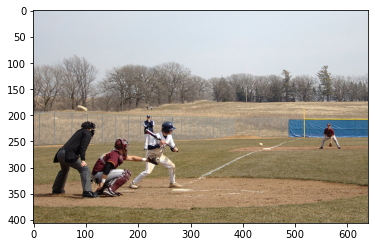

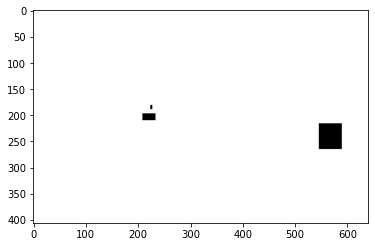

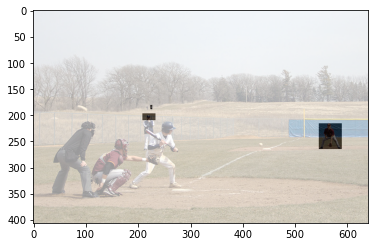

In [10]:
index = 24

# 이미지
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 마스크
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 합성
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


In [11]:
# 데이터 처리 클래스와 데이터 확장 클래스 import 
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    """
    이미지와 마스크, 어노테이션 전처리 클래스
    학습 시 추론 시 서로 다르게 동작
    학습 시에는 데이터 확장 수행
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSON에서 어노테이션을 사전에 저장
                add_neck(),  # 어노테이션 데이터의 순서 변경 및 목의 어노테이션 데이터 추가
                aug_scale(),  # 확대 축고
                aug_rotate(),  # 회전
                aug_croppad(),  # 자르기
                aug_flip(),  # 좌우반전
                remove_illegal_joint(),  # 이미지에서 밀려나온 아노테이션 제거
                # Normalize_Tensor()  # 색상 정보의 표준화 및 텐서화
                no_Normalize_Tensor()  # 여기서는 색상 정보의 표준화 생략
            ]),
            'val': Compose([
                # 검증 생략
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss

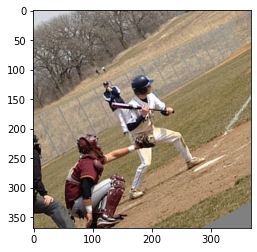

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


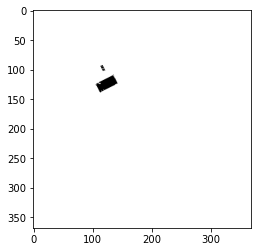

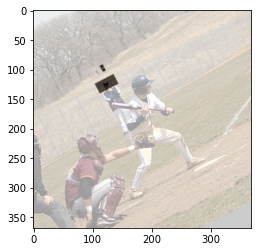

In [12]:
# 동작확인
# 이미지 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 이미지 전처리
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

# 이미지 표시
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# 마스크 표시
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 합성 RGB 정보 갖추기
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

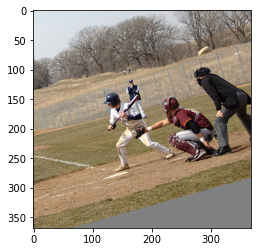

In [13]:
# SciPy가 없어서 Prompt에서 설치했음
from utils.dataloader import get_ground_truth

# 이미지 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 이미지 전처리
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPose의 어노테이션 데이터 생성
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 왼쪽 팔꿈치의 히트맵 확인
plt.imshow(img)
plt.show()

In [14]:
# 왼쪽 팔꿈치의 히트맵 확인

#  원래 이미지
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 주의: 히트맵의 이미지 크기가 1/8로 되어 있어 확대한다.

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: any() missing 1 required positional arguments: "dim"

In [15]:
# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: any() missing 1 required positional arguments: "dim"

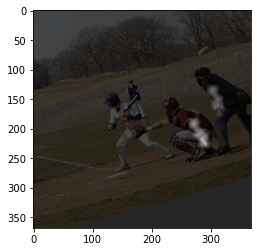

In [16]:
# 왼쪽 팔꿈치와 왼쪽 손목에 PAF 확인
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x벡터의 PAF

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()


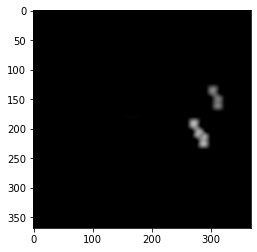

In [17]:
# PAF만 표시
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x벡터의 PAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)

In [21]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCO Cocokeypoints의 데이터셋을 작성하는 클래스. 파이토치 데이터셋 클래스 상솟

    Attributes
    ----------
    img_list : 리스트
        이미지
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''이미지 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''이미지의 텐서 형식 데이터, 어노테이션, 마스크 획득'''

        # 1. 이미지 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]

        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]

        # 3. 이미지 전처리
        meta_data, img, mask_miss = self.transform(
            self.phase, meta_data, img, mask_miss)

        # 4. 정답 어노테이션 데이터 획득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. 마스크 데이터는 RGB가 (1, 1, 1)또는 (0, 0, 0)이므로 차원을 낮춘다.
        # 마스크된 위치는 값이 0, 그렇지 않으면 1
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. 채널이 맨 끝에 있어 순서 변경
        # 예：paf_mask：torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask


In [22]:
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# 데이터 꺼내기 예시
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


In [23]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복으로 변환
item = next(batch_iterator)  # 첫 번째 요소를 꺼낸다.
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


In [24]:
# 패키지 import
import torch
import torch.nn as nn
from torch.nn import init
import torchvision

In [25]:
class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()

        # Feature 모듈
        self.model0 = OpenPose_Feature()

        # Stage 모듈
        # PAFs측
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')

        # confidence heatmap 측
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')

    def forward(self, x):
        """순전파 정의"""

        # Feature 모듈
        out1 = self.model0(x)

        # Stage1
        out1_1 = self.model1_1(out1)  # PAFs측
        out1_2 = self.model1_2(out1)  # confidence heatmap側

        # CStage2
        out2 = torch.cat([out1_1, out1_2, out1], 1)  # 次元1のチャネルで結合
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)

        # Stage3
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)

        # Stage4
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)

        # Stage5
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)

        # Stage6
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        # 손실 계산을 위하여 각 스테이지 결과 계산
        saved_for_loss = []
        saved_for_loss.append(out1_1)  # PAFs 측
        saved_for_loss.append(out1_2)  # confidence heatmap 측
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        # 최종적인 PAFs의 out16_1과 confidence heatmap의 out6_2,
        # 손실 계산용으로 각 단계에서 PAFs와 히트맵을 저장한 saved_for_loss 출력
        # out6_1：torch.Size([minibatch, 38, 46, 46])
        # out6_2：torch.Size([minibatch, 19, 46, 46])
        # saved_for_loss:[out1_1, out_1_2, ・・・, out6_2]

        return (out6_1, out6_2), saved_for_loss

In [26]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()

        # VGG-19 최초 열 개의 합성곱을 이용
        # 처음 실행할 때는 학습된 파라미터를 다운로드하여 실행에 시간이 걸린다.
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        # VGG-19 최초 열 개의 합성곱 층까지
        model['block0'] = vgg19.features[0:23]

        # 나머지는 새로운 합성곱 층을 두 개 준비
        model['block0'].add_module("23", torch.nn.Conv2d(
            512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("24", torch.nn.ReLU(inplace=True))
        model['block0'].add_module("25", torch.nn.Conv2d(
            256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("26", torch.nn.ReLU(inplace=True))

        self.model = model['block0']

    def forward(self, x):
        outputs = self.model(x)
        return outputs


In [27]:
def make_OpenPose_block(block_name):
    """
    구성 변수에서 오픈포즈 Stage 모듈의 블록 작성
    nn.Module이 아닌 nn.Sequential로 한다.
    """

    # 1. 구성의 사전형 변수 block를 작성하여 네트워크를 생성시킨다.
    # 먼저 모든 패턴의 사전을 준비하여 block_name인수만 생성한다.
    blocks = {}
    # Stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    # Stages 2 - 6
    for i in range(2, 7):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # block_name 인수의 구성 사전을 꺼낸다.
    cfg_dict = blocks[block_name]

    # 구성 내용을 리스트 변수 layers에 저장
    layers = []

    # 0번째부터 마지막 층까지 작성
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    # 3. layers를 Sequential로 한다.
    # 단 마지막에 ReLU는 필요 없어 직전까지 사용한다.
    net = nn.Sequential(*layers[:-1])

    # 4. 초기화 함수를 설정하여 합성곱 층을 초기화
    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    net.apply(_initialize_weights_norm)

    return net


In [28]:
# 모델 정의
net = OpenPoseNet()
net.train()

# batch Size 정의
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 계산
outputs = net(dummy_img)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\kodhd/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████████████████████████████████████████████████████████| 574673361/574673361 [00:13<00:00, 41599074.99it/s]


In [29]:
print(outputs)

((tensor([[[[ 5.4186e-06,  1.2876e-06, -3.9963e-06,  ...,  3.1974e-05,
            9.7999e-06, -9.5761e-06],
          [ 1.5411e-05,  4.3416e-06, -1.8826e-05,  ..., -2.4145e-07,
            6.3466e-06, -6.4814e-06],
          [ 6.0582e-06,  6.5844e-06, -2.6931e-05,  ..., -7.5770e-06,
           -1.1281e-05,  1.7673e-06],
          ...,
          [ 4.5832e-05,  3.8924e-05,  2.1919e-05,  ...,  1.2998e-05,
            3.6686e-05, -1.2740e-06],
          [ 2.5441e-05,  4.6611e-05,  4.9368e-05,  ..., -7.8373e-06,
            1.3268e-05, -9.7833e-06],
          [ 3.2015e-05,  3.6315e-05,  6.3998e-05,  ...,  1.3193e-05,
            2.5195e-05,  3.8679e-06]],

         [[-1.9515e-05,  1.0549e-05,  9.8997e-06,  ...,  1.2182e-05,
            1.8306e-05,  1.2134e-05],
          [-3.8874e-05, -1.2499e-05, -1.7030e-05,  ...,  3.6201e-05,
            1.8966e-05,  1.2045e-05],
          [-8.1013e-06, -6.5943e-07,  1.0858e-05,  ...,  4.8475e-05,
            1.9729e-05,  1.1502e-05],
          ...,
   

## 4.5 텐서보드 X를 사용한 네트워크 시각화 기법

In [30]:
from utils.openpose_net import OpenPoseNet
# 모델 준비
net = OpenPoseNet()
net.train()

OpenPoseNet(
  (model0): OpenPose_Feature(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, ker

In [34]:
# # 1. 텐서보드X의 저장 클래스 호출
# from tensorboardX import SummaryWriter

# # 2. tbX 폴더에 저장할 writer 준비
# # tbX 폴더가 없으면 자동으로 생성
# writer = SummaryWriter("./tbX/")


# # 3. 네트워크에 넣을 더미 데이터 작성
# batch_size = 2
# dummy_img = torch.rand(batch_size, 3, 368, 368)

# # 4. 오픈포즈의 인스턴스 net에 더미 데이터인 dummy_img를 전달할 때 graph를 writer에 저장
# writer.add_graph(net, (dummy_img, ))
# writer.close()

# # 5. 명령 프롬프트를 열고 tbX가 있는 4_pose_estimation 폴더까지 이동
# # 다음 명령을 실행

# # tensorboard --logdir="./tbX/"

# # 이후、http://localhost:6006에 접근